<a href="https://colab.research.google.com/github/andBabaev/ds_school_2020/blob/master/task%202/Babaev_Andrei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CPI.** A Python library that quickly adjusts U.S. dollars for inflation using the Consumer Price Index (CPI).

In [790]:
!pip install cpi

In [0]:
import warnings
warnings.simplefilter('ignore')

import json
import cpi

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

[TMDB 5000 Movie Dataset](https://www.kaggle.com/tmdb/tmdb-movie-metadata#tmdb_5000_movies.csv) was selected (tmdb_5000_movies.csv).

Let's read data

In [792]:
data = pd.read_csv('drive/My Drive/tmdb_5000_movies.csv')
data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


# Data clearning

In [793]:
#delete unstructured data
data = data.drop(['tagline', 'overview', 'homepage', 'original_title', 'id', 'status'], axis=1)
data.shape

(4803, 14)

In [0]:
data = data[(data['runtime']!=0.0) &
            (data['revenue']!=0.0)]

In [795]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3375 entries, 0 to 4798
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3375 non-null   int64  
 1   genres                3375 non-null   object 
 2   keywords              3375 non-null   object 
 3   original_language     3375 non-null   object 
 4   popularity            3375 non-null   float64
 5   production_companies  3375 non-null   object 
 6   production_countries  3375 non-null   object 
 7   release_date          3375 non-null   object 
 8   revenue               3375 non-null   int64  
 9   runtime               3375 non-null   float64
 10  spoken_languages      3375 non-null   object 
 11  title                 3375 non-null   object 
 12  vote_average          3375 non-null   float64
 13  vote_count            3375 non-null   int64  
dtypes: float64(3), int64(3), object(8)
memory usage: 395.5+ KB


In [796]:
data.head(3)

,budget,genres,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Spectre,6.3,4466


# Feature engineering

In [0]:
data['release_date'] = pd.to_datetime(data['release_date'])
data.sort_values('release_date', inplace=True)
data['release_month'] = data['release_date'].dt.month
data['release_dayofweek'] = data['release_date'].dt.dayofweek
data['release_year'] = data['release_date'].dt.year

data['decade'] = data['release_year'].apply(lambda x: str(x)[:-1])

In [798]:
%%time
def fix_inflation(row):
    row['revenue_fix'] = cpi.inflate(row['revenue'], row['release_date'])
    row['budget_fix'] = cpi.inflate(row['budget'], row['release_date'])

    return row

data = data.apply(fix_inflation,axis=1)

CPU times: user 7 s, sys: 17.9 ms, total: 7.02 s
Wall time: 7.02 s


In [799]:
%%time
def get_dict_value(row, feature, target_key='name'):
    list_ = json.loads(row[feature])
    row[feature+'_1'] = list_[0][target_key] if list_ else None
    #row[feature+'_2'] = list_[1][target_key] if len(list_)>2 else None

    return row
    
data = data.apply(get_dict_value, args=('genres',), axis=1)
data = data.apply(get_dict_value, args=('production_companies',), axis=1)
data = data.apply(get_dict_value, args=('production_countries',), axis=1)

CPU times: user 10.8 s, sys: 15.8 ms, total: 10.9 s
Wall time: 10.9 s


In [0]:
clearned_data = data.copy()
clearned_data.drop(['genres', 'keywords', 'production_companies', 
                    'production_countries', 'spoken_languages', 
                    'release_date', 'popularity', 'vote_count', 
                    'revenue', 'budget', 'title', 'vote_average'], axis=1, inplace=True
                   )

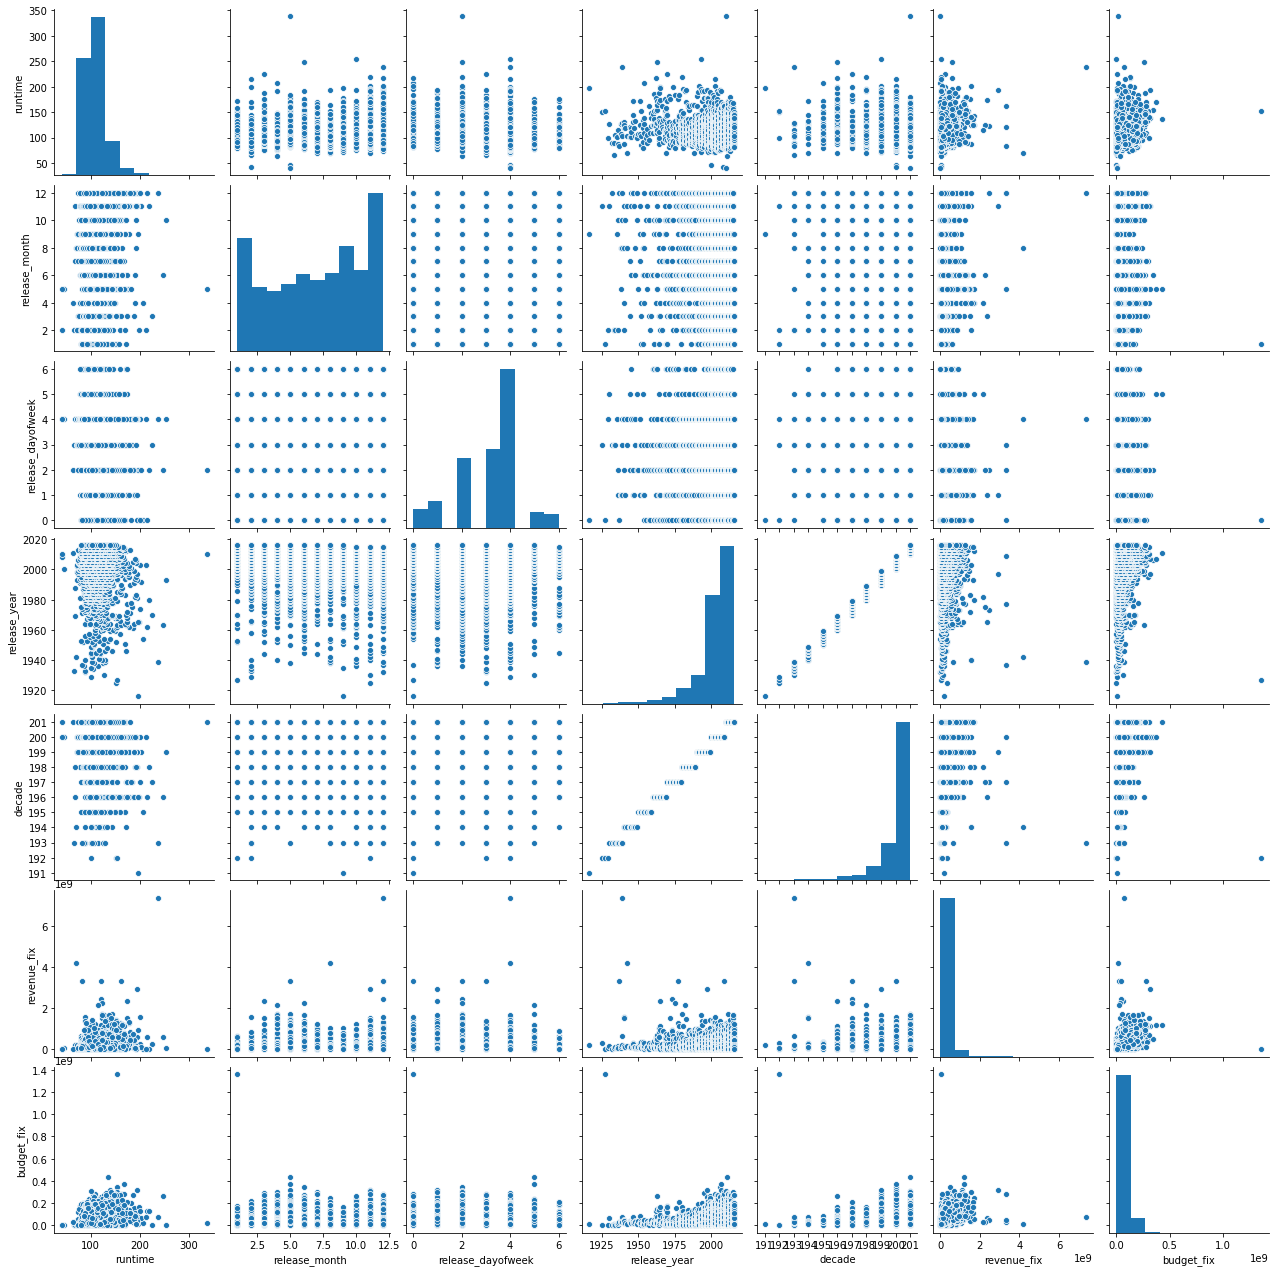

In [801]:
sns.pairplot(clearned_data)

In [802]:
clearned_data.describe(include=['object'])

,original_language,decade,genres_1,production_companies_1,production_countries_1
count,3375,3375,3374,3325,3354
unique,28,11,19,810,46
top,en,200,Drama,Paramount Pictures,United States of America
freq,3232,1397,792,247,2335


In [0]:
clearned_data['genres_1'].fillna('na', inplace=True)
clearned_data['production_companies_1'].fillna('na', inplace=True)
clearned_data['production_countries_1'].fillna('na', inplace=True)


In [0]:
for feature, threshold in zip (['genres_1', 'production_companies_1', 'production_countries_1', 'original_language'], [20, 6, 2000, 3000]):
    count_data = clearned_data[feature].value_counts()
    values_for_replacing = count_data[count_data < threshold].index
    clearned_data[feature] = clearned_data[feature].apply(lambda x: 'Others' if x in values_for_replacing else x)


In [805]:
clearned_data['production_companies_1'].value_counts()

Others                                    1086
Paramount Pictures                         247
Universal Pictures                         231
Columbia Pictures                          167
Twentieth Century Fox Film Corporation     163
                                          ... 
Worldview Entertainment                      6
Universal Studios                            6
Walt Disney                                  6
Tig Productions                              6
DreamWorks                                   6
Name: production_companies_1, Length: 74, dtype: int64

In [806]:
clearned_data.describe(include=['object'])

,original_language,decade,genres_1,production_companies_1,production_countries_1
count,3375,3375,3375,3375,3375
unique,2,11,17,74,2
top,en,200,Drama,Others,United States of America
freq,3232,1397,792,1086,2335


In [807]:
clearned_data.describe()

,runtime,release_month,release_dayofweek,release_year,revenue_fix,budget_fix
count,3375.000000,3375.000000,3375.000000,3375.000000,3.375000e+03,3.375000e+03
mean,110.414815,6.980444,3.138074,2001.850963,1.751727e+08,5.369506e+07
std,21.033516,3.357423,1.332604,13.120210,3.030699e+08,5.921285e+07
min,41.000000,1.000000,0.000000,1916.000000,8.341855e+00,0.000000e+00
25%,96.000000,4.000000,2.000000,1998.000000,2.456664e+07,1.458648e+07
50%,106.000000,7.000000,3.000000,2005.000000,7.959743e+07,3.577418e+07
75%,121.000000,10.000000,4.000000,2010.000000,2.046478e+08,7.470915e+07
max,338.000000,12.000000,6.000000,2016.000000,7.352042e+09,1.361292e+09


In [0]:
#clearned_data['budget_fix'] = clearned_data['budget_fix'].apply(lambda x: clearned_data['budget_fix'].median() if x==0 else x)

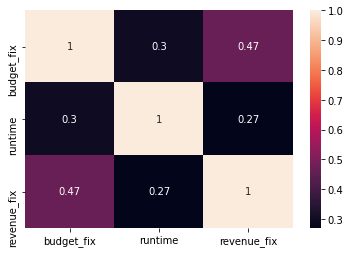

In [809]:
sns.heatmap(clearned_data[['budget_fix',	'runtime',  'revenue_fix']].corr(), annot=True)

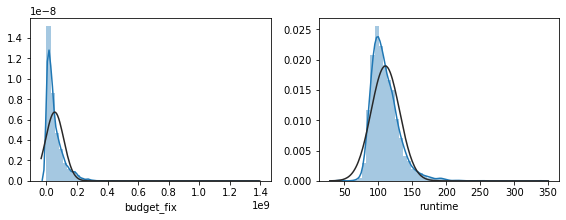

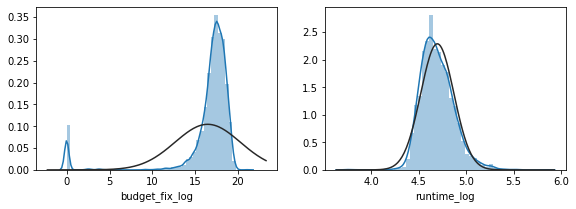

In [810]:
plt.figure(figsize=(25, 3))
numerical_col = ['budget_fix',	'runtime']
for idx, feature in enumerate(numerical_col, 1):
    plt.subplot(1, 5, idx) 
    sns.distplot(clearned_data[feature], fit=stats.norm)

#log transformation
plt.figure(figsize=(25, 3))
for idx, feature in enumerate(numerical_col, 1):
    plt.subplot(1, 5, idx)    
    clearned_data[feature+'_log'] = np.log(clearned_data[feature]+1)
    sns.distplot(clearned_data[feature+'_log'], fit=stats.norm)

# New target variable

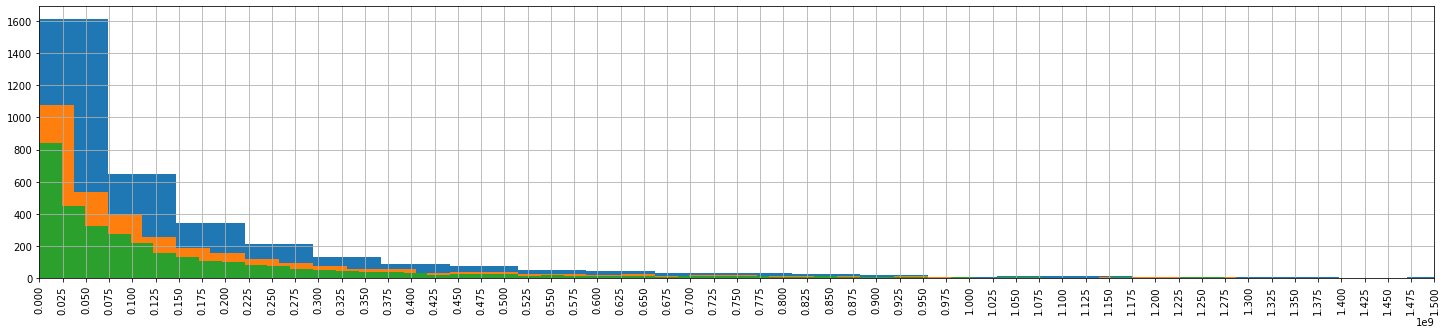

In [811]:
plt.figure(figsize=(25, 5))
clearned_data['revenue_fix'].hist(bins=100)
clearned_data['revenue_fix'].hist(bins=200)
clearned_data['revenue_fix'].hist(bins=300,xrot=90)
lim = 1.5*10**9
plt.xlim(0, lim)
plt.xticks(np.linspace(0, lim, 61));
#sns.distplot(clearned_data['revenue'], 200)

class 0 - revenue < 39M

class 1 - revenue = 39M-141M

class 2 - revenue > 141M




In [812]:
qu1 = clearned_data['revenue_fix'].quantile(0.33)
qu2 = clearned_data['revenue_fix'].quantile(0.66)
print(qu1, qu2)
def get_classes(row):
    class_ = None
    if row['revenue_fix'] < qu1:
        row['revenue_class'] = 0
    elif qu1 <= row['revenue_fix'] < qu2:
        row['revenue_class'] = 1
    elif row['revenue_fix'] >= qu2:
        row['revenue_class'] = 2
    return row

clearned_data = clearned_data.apply(get_classes, axis=1)
clearned_data['revenue_class'].value_counts(normalize=True)

39146044.70122607 141064203.59021637


2    0.340148
0    0.330074
1    0.329778
Name: revenue_class, dtype: float64

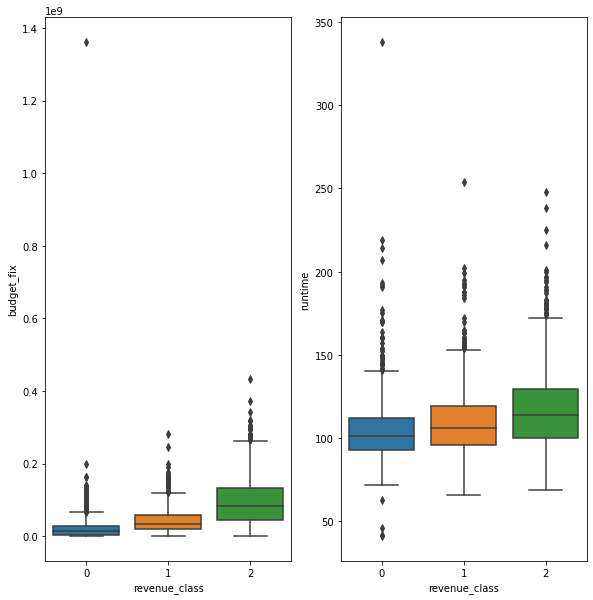

In [813]:
plt.figure(figsize=(15, 10))
numerical_col = ['budget_fix',	'runtime']
for idx, feature in enumerate(numerical_col, 1):
    plt.subplot(1, 3, idx)
    sns.boxplot("revenue_class", feature, data=clearned_data)

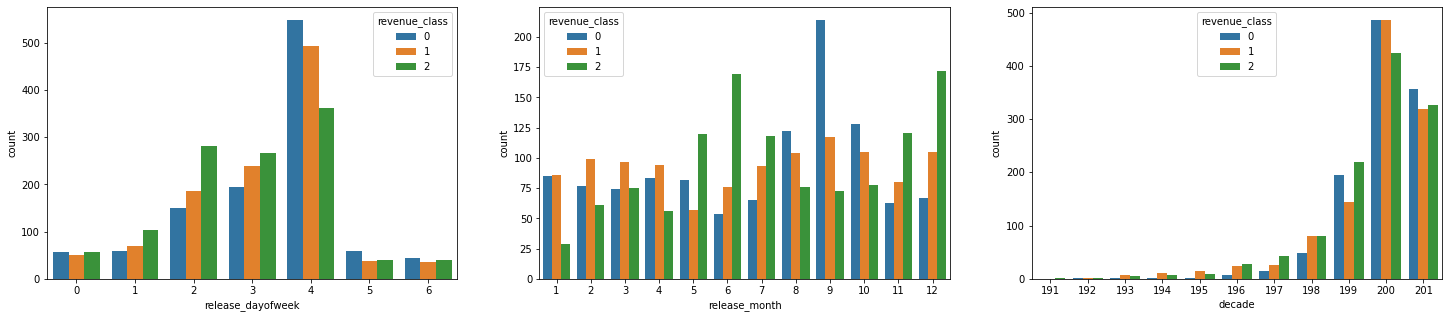

In [814]:
plt.figure(figsize=(25, 5))
numerical_col = ['release_dayofweek','release_month', 'decade']
for idx, feature in enumerate(numerical_col, 1):
    plt.subplot(1, 3, idx)
    sns.countplot(feature, hue="revenue_class", data=clearned_data)

# ML

## Default parameters

In [0]:
X_cat_oh = pd.get_dummies(clearned_data[['genres_1', 
                                        'production_companies_1', 
                                        'production_countries_1', 
                                         'release_dayofweek',
                                         'release_month',
                                         'decade',
                                         ]])
X_numeric = clearned_data[['budget_fix_log', 'runtime_log']]

y = clearned_data['revenue_class']

shuffle=False because I want to train models to predict revenue_class for modern movies

In [816]:
r_state = 42
X_cat_oh_train, X_cat_oh_test, y_train, y_test = train_test_split(X_cat_oh, y, 
                                                                  test_size=0.2, 
                                                                  shuffle=False, 
                                                                  #stratify=y,
                                                                  random_state=r_state,
                                                                  )

X_numeric_train, X_numeric_test = train_test_split(X_numeric,
                                                    test_size=0.2, 
                                                    shuffle=False,
                                                    #stratify=y,
                                                    random_state=r_state,
                                                   )

scaler = StandardScaler()
X_numeric_train_scaled = scaler.fit_transform(X_numeric_train)
X_numeric_test_scaled = scaler.transform(X_numeric_test)

print('Train classes distribution', y_train.value_counts(normalize=True), 'Test classes distribution', y_test.value_counts(normalize=True), sep='\n')

X_train = np.hstack([X_numeric_train_scaled, X_cat_oh_train, ])
X_test = np.hstack([X_numeric_test_scaled, X_cat_oh_test, ])

print('\nTrain data', X_train.shape, '\nTest data', X_test.shape)

Train classes distribution
2    0.339630
0    0.331111
1    0.329259
Name: revenue_class, dtype: float64
Test classes distribution
2    0.342222
1    0.331852
0    0.325926
Name: revenue_class, dtype: float64

Train data (2700, 108) 
Test data (675, 108)


In [817]:
model_list = [LogisticRegression(random_state=r_state), 
              SGDClassifier(random_state=r_state),
              RandomForestClassifier(random_state=r_state),
              DecisionTreeClassifier(random_state=r_state),
              KNeighborsClassifier(),
              GradientBoostingClassifier(random_state=r_state)
              ]
model_testing = []
for clf in model_list:
    d = {}
    d['model'] = type(clf).__name__
    clf.fit(X_train, y_train)
    d['accuracy'] = round(accuracy_score(y_test, clf.predict(X_test)), 4)
    model_testing.append(d)

pd.DataFrame(model_testing).sort_values('accuracy', ascending=False)

,model,accuracy
2,RandomForestClassifier,0.6578
5,GradientBoostingClassifier,0.6533
0,LogisticRegression,0.6207
3,DecisionTreeClassifier,0.5689
1,SGDClassifier,0.5378
4,KNeighborsClassifier,0.5244


Add polynimail features

In [818]:
poly_generator = PolynomialFeatures(7, include_bias=False)
X_numeric_train_p = poly_generator.fit_transform(X_numeric_train)
X_numeric_test_p = poly_generator.transform(X_numeric_test)

scaler = StandardScaler()
X_numeric_train_poly_scaled = scaler.fit_transform(X_numeric_train_p)
X_numeric_test_poly_scaled = scaler.transform(X_numeric_test_p)

X_train_poly = np.hstack([X_numeric_train_poly_scaled, X_cat_oh_train, ])
X_test_poly = np.hstack([X_numeric_test_poly_scaled, X_cat_oh_test, ])

print('\nTrain data', X_train.shape, '\nTest data', X_test.shape)


Train data (2700, 108) 
Test data (675, 108)


In [819]:
model_list = [LogisticRegression(random_state=r_state), 
              SGDClassifier(random_state=r_state),
              RandomForestClassifier(random_state=r_state),
              DecisionTreeClassifier(random_state=r_state),
              KNeighborsClassifier(),
              GradientBoostingClassifier(random_state=r_state)
              ]
model_testing_poly = []
for clf in model_list:
    d = {}
    d['model'] = type(clf).__name__ + '_poly'
    clf.fit(X_train_poly, y_train)
    d['accuracy'] = round(accuracy_score(y_test, clf.predict(X_test_poly)), 4)
    model_testing.append(d)

pd.DataFrame(model_testing+
             model_testing_poly).sort_values('accuracy', ascending=False)

,model,accuracy
11,GradientBoostingClassifier_poly,0.6607
2,RandomForestClassifier,0.6578
6,LogisticRegression_poly,0.6563
5,GradientBoostingClassifier,0.6533
0,LogisticRegression,0.6207
8,RandomForestClassifier_poly,0.6119
7,SGDClassifier_poly,0.5985
10,KNeighborsClassifier_poly,0.5778
3,DecisionTreeClassifier,0.5689
9,DecisionTreeClassifier_poly,0.5467


## Tuning of parameters of models

### Logistic Regression

{'C': 0.010526315789473684} 0.6696296296296296


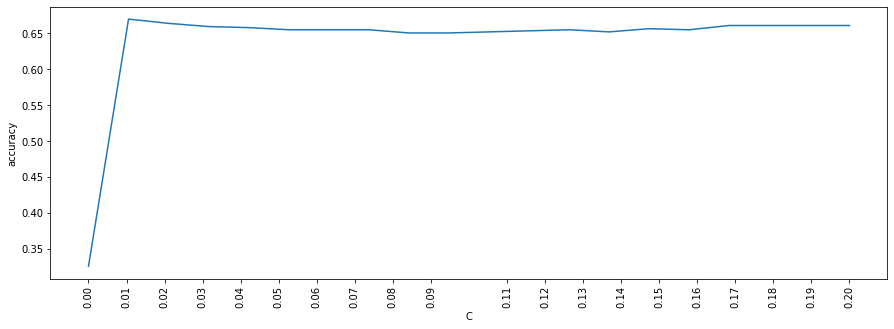

In [820]:
#grid search without cross_validation
def accuracy_cv(estimator, X, y):
    estimator.fit(X, y)
    return accuracy_score(y_test, estimator.predict(X_test_poly))

param_dict = {'C':np.linspace(0, 0.2, 20)}
cv = [(slice(None), slice(None))]
clf = LogisticRegression(random_state=r_state)
gs = GridSearchCV(estimator=clf, param_grid=param_dict, 
                  scoring=accuracy_cv, cv=cv, n_jobs=-1)
gs = gs.fit(X_train_poly, y_train)
print(gs.best_params_, gs.best_score_)


tuned_models = []
d = {}
d['model'] = type(clf).__name__ + '_poly_tuned'
d['accuracy'] = round(gs.best_score_, 4)
tuned_models.append(d)


plt.figure(figsize=(15,5))
plt.plot(gs.param_grid['C'], gs.cv_results_['mean_test_score'])
plt.xlabel('C')
plt.ylabel('accuracy')
plt.xticks(gs.param_grid['C'].round(2), rotation=90);

### Random forest

In [821]:
def accuracy_cv(estimator, X, y):
    estimator.fit(X, y)
    return accuracy_score(y_test, estimator.predict(X_test))

param_dict = {'n_estimators': np.linspace(50, 150, 5).astype(np.int32),
              'max_features': np.arange(40, 71, 5)}
cv = [(slice(None), slice(None))]
clf = RandomForestClassifier(random_state=r_state)
gs = GridSearchCV(estimator=clf, param_grid=param_dict, 
                  scoring=accuracy_cv, cv=cv, n_jobs=11, verbose=1)
gs = gs.fit(X_train, y_train)
print(gs.best_params_, gs.best_score_)

Fitting 1 folds for each of 35 candidates, totalling 35 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  35 out of  35 | elapsed:  1.1min finished


{'max_features': 65, 'n_estimators': 50} 0.6666666666666666


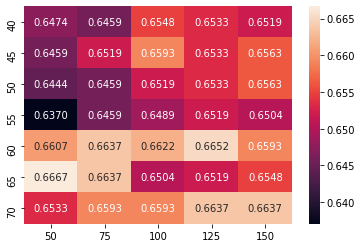

In [822]:
values = gs.cv_results_['mean_test_score'].reshape((gs.param_grid['max_features'].shape[0],
                                                    gs.param_grid['n_estimators'].shape[0]))
temp_df = pd.DataFrame(values, columns=gs.param_grid['n_estimators'], index=gs.param_grid['max_features'])
sns.heatmap(temp_df, annot=True, fmt='.4f');

In [0]:
d = {}
d['model'] = type(clf).__name__ + '_tuned'
d['accuracy'] = round(gs.best_score_, 4)
tuned_models.append(d)

### Gradient Boosting

In [824]:
def accuracy_cv(estimator, X, y):
    estimator.fit(X, y)
    return accuracy_score(y_test, estimator.predict(X_test_poly))

param_dict = {'n_estimators': np.linspace(50, 150, 5).astype(np.int32),
              'max_features': np.arange(0, 51, 5)}
cv = [(slice(None), slice(None))]
clf = GradientBoostingClassifier(random_state=r_state)
gs = GridSearchCV(estimator=clf, param_grid=param_dict, 
                  scoring=accuracy_cv, cv=cv, n_jobs=11, verbose=1)
gs = gs.fit(X_train_poly, y_train)
print(gs.best_params_, gs.best_score_)

Fitting 1 folds for each of 55 candidates, totalling 55 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  55 out of  55 | elapsed:  2.9min finished


{'max_features': 15, 'n_estimators': 100} 0.6725925925925926


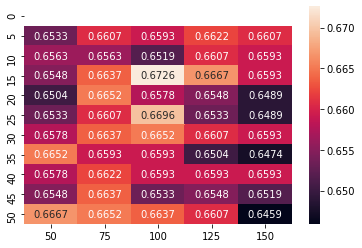

In [825]:
values = gs.cv_results_['mean_test_score'].reshape((gs.param_grid['max_features'].shape[0],
                                                    gs.param_grid['n_estimators'].shape[0]))
temp_df = pd.DataFrame(values, columns=gs.param_grid['n_estimators'], index=gs.param_grid['max_features'])
sns.heatmap(temp_df, annot=True, fmt='.4f');

In [0]:
d = {}
d['model'] = type(clf).__name__ + '_poly_tuned'
d['accuracy'] = round(gs.best_score_, 4)
tuned_models.append(d)

### KNN

In [827]:
def accuracy_cv(estimator, X, y):
    estimator.fit(X, y)
    return accuracy_score(y_test, estimator.predict(X_test_poly))

param_dict = {'n_neighbors': np.arange(1, 50)}
cv = [(slice(None), slice(None))]
clf = KNeighborsClassifier()
gs = GridSearchCV(estimator=clf, param_grid=param_dict, 
                  scoring=accuracy_cv, cv=cv, n_jobs=11, verbose=1)
gs = gs.fit(X_train_poly, y_train)
print(gs.best_params_, gs.best_score_)

Fitting 1 folds for each of 49 candidates, totalling 49 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:    5.6s


{'n_neighbors': 31} 0.642962962962963


[Parallel(n_jobs=11)]: Done  49 out of  49 | elapsed:    9.6s finished


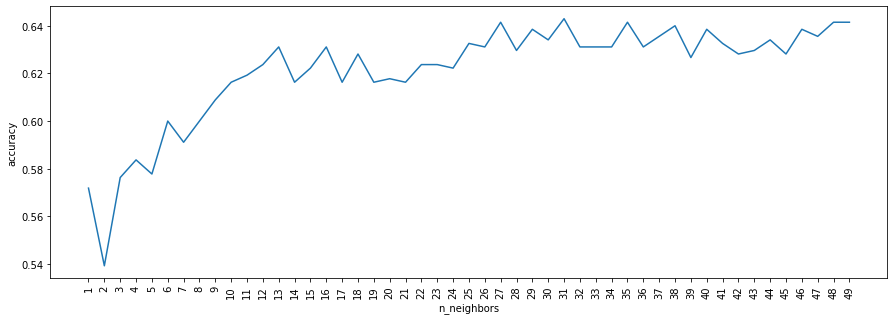

In [828]:
plt.figure(figsize=(15,5))
plt.plot(gs.param_grid['n_neighbors'], gs.cv_results_['mean_test_score'])
plt.xlabel('n_neighbors')
plt.ylabel('accuracy')
plt.xticks(gs.param_grid['n_neighbors'].round(2), rotation=90);

In [0]:
d = {}
d['model'] = type(clf).__name__ + '_poly_tuned'
d['accuracy'] = round(gs.best_score_, 4)
tuned_models.append(d)


# Model rating

In [830]:
pd.DataFrame(model_testing+
             model_testing_poly+
             tuned_models).sort_values('accuracy', ascending=False)

,model,accuracy
14,GradientBoostingClassifier_poly_tuned,0.6726
12,LogisticRegression_poly_tuned,0.6696
13,RandomForestClassifier_tuned,0.6667
11,GradientBoostingClassifier_poly,0.6607
2,RandomForestClassifier,0.6578
6,LogisticRegression_poly,0.6563
5,GradientBoostingClassifier,0.6533
15,KNeighborsClassifier_poly_tuned,0.6430
0,LogisticRegression,0.6207
8,RandomForestClassifier_poly,0.6119


In [832]:
clf = GradientBoostingClassifier(max_features=15, n_estimators=100, random_state=r_state)
clf.fit(X_train_poly, y_train)
print(classification_report(y_test, clf.predict(X_test_poly)))

              precision    recall  f1-score   support

           0       0.66      0.80      0.73       220
           1       0.55      0.46      0.50       224
           2       0.79      0.76      0.77       231

    accuracy                           0.67       675
   macro avg       0.67      0.67      0.67       675
weighted avg       0.67      0.67      0.67       675



# Сonclusions

Good ideas:

*   adjusting inflation
*   the creation of two categories of production_countries (US and Others)
*   replacing years to decades
*   log transformation for real features

Adding polynomial features increased the accuracy of all models except  Decision Tree. 

Tuning of parameters of models increased accuracy.


**The best model:**

| Model | Accuracy |
| --- | --- |
| GradientBoosting(max_features=15, n_estimators=100)+polynomial features | 0.6726 |

For all algorithms, the quality of work in class_1 is worse than in class_0 and class_2.

